# Course Machine Learning for Particle Physicists
##  PhD course Spring 2020
## Lesson VII : Transfer Learning
###  by Veronica Sanz (Universitat de Valencia/ IFIC)

We are going to use PYTORCH and FAST.AI, to learn another environment

In [0]:
from __future__ import division 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import error_rate
from tqdm import tqdm
import fastai
import matplotlib as mpl
import os
import glob


In [0]:
# Download the MNIST data
path = untar_data(URLs.MNIST)
# tfms = get_transforms(max_rotate=20,max_lighting=0.3)
# data = ImageDataBunch.from_folder(path,ds_tfms=tfms, size=224, bs=8, num_workers=3).normalize()
data = ImageDataBunch.from_folder(path, train='training', valid='testing')

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 10, 60000, 10000)

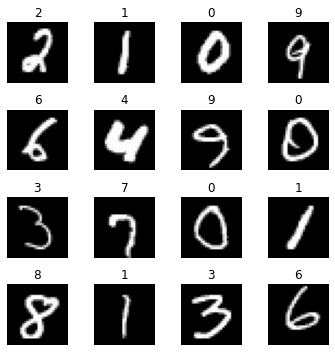

In [0]:
data.show_batch(4,figsize=(5,5))

We are going to use pre-trained models on the MNIST dataset

Play with them and look-up the options for cnn_learner and fit

## The fastai library includes several pretrained models from torchvision:

- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.374328,0.243908,0.921600,06:04


In [0]:
learn = cnn_learner(data, models.squeezenet1_0, metrics=accuracy)
learn.fit(1)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.518039,0.721636,0.881600,01:06


## Now let's see how we would use this in a particle physics environment

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


The dataset and models can be downloaded from this link

https://drive.google.com/open?id=1yHBIVsH-6MjnwpQN6TceTalERL1SZqeO

then place it in your local directory or in gdrive

In [0]:
path = Path('gdrive/My Drive/image_dataset/')

In [0]:
path.ls()

[PosixPath('gdrive/My Drive/image_dataset/test'),
 PosixPath('gdrive/My Drive/image_dataset/train'),
 PosixPath('gdrive/My Drive/image_dataset/models')]

Data augmentation: Transformations on the data, cropping/rotating/flipping


In [0]:
tfms = get_transforms(rand_resize_crop(224),max_rotate=0.,flip_vert=True, max_warp=0.)

### Here the datablock API will fetch the data already splitted in 80% train and 20% validation images and labbel the images according to the folder names $signal$ and $backgroun$, this is automatically done by the function from_folder() and passing the main path of the data and the $train/valid$ file names.

In [0]:
np.random.seed(42) # random seed for reproducibility. Remember to change in each run
data = ImageDataBunch.from_folder(path, train="train", valid="test",
        ds_tfms=tfms, size=224, bs=24, num_workers=4, 
                                  ).normalize()

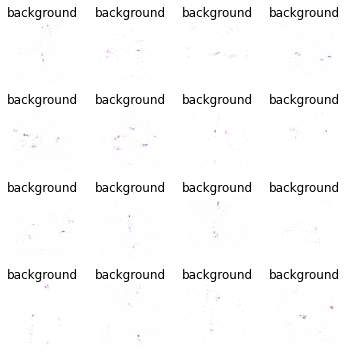

In [0]:
data.show_batch(4,figsize=(5,5))

In [0]:
data.classes

['background', 'signal']

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['background', 'signal'], 2, 90, 40)

In [0]:
trn_count = np.bincount(data.train_ds.y)
val_count = np.bincount(data.valid_ds.y)

In [0]:
for i in range(len(data.classes)):
    print('{} of images for {}'.format(trn_count[i], data.train_ds.classes[i]))

80 of images for background
10 of images for signal


In [0]:
# Let's start with ResNet
model = models.resnet34

### vision.learner is the module that defines the cnn_learner method, to easily get a model suitable for transfer learning.

In [0]:
# Check out the function cnn_learner, play with the parameters
learn = cnn_learner(data, model, pretrained=True, metrics=[accuracy,error_rate]).mixup(alpha=0.45)

In [0]:
learn.load('resnet_34_LSC_kaiming_uni_10');

In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

## We use the pre-trained model to get predictions in our dataset

In [0]:
#set the model in evaluation mode:
learn.model.eval();

In [0]:
data.classes

['background', 'signal']

In [0]:
learn.predict(data.valid_ds.x[0])

(Category signal, tensor(1), tensor([0.0393, 0.9607]))

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

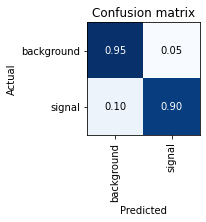

In [0]:
interp.plot_confusion_matrix(normalize=True,figsize=(3,3))

You can save your trained model here and reload again for new predictions

In [0]:
learn.export(file = 'resnet50.pkl')